In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from moviepy.editor import VideoFileClip # mp4 to gif
import time, _pickle
plt.style.use('seaborn')

g = 9.8

## Создание модели HNN

In [ ]:
# Реализуем ее с помощью класса, так как у нас не классический учет ошибки
class HNN(tf.keras.Model):

  def __init__(self, shapes, activation='tanh'):
    super(HNN, self).__init__()
    self.input_layer = tf.keras.layers.Input(shapes[0], batch_size=70)
    self.hidden_layer_1 = tf.keras.layers.Dense(shapes[1], activation=activation)
    self.hidden_layer_2 = tf.keras.layers.Dense(shapes[2], activation=activation)
    self.output_layer = tf.keras.layers.Dense(1) # Один выходной слой всегда, поскольку мы создаем гамильтониан
    
    Mat = np.eye(shapes[0]) # Матрица, которая примет на вход производные, поменяет их местами и поставит минус
    Mat = np.concatenate([Mat[shapes[0] // 2:], -Mat[:shapes[0] // 2]], axis=0)
    self.Mat = tf.constant(Mat, dtype='float64')
    self.history_loss = []

  def call(self, x):
    y = self.hidden_layer_1(x)
    y = self.hidden_layer_2(y)
    return self.output_layer(y)

  def forward(self, x):
    with tf.GradientTape() as tape:
      y = self.hidden_layer_1(x)
      y = self.hidden_layer_2(y)
      y = self.output_layer(y)
    y = tape.gradient(y, x)
    y = y @ self.Mat
    return y

def fit_HNN(model, x, y, batch_size=36, learning_rate=1e-4, epochs=100, verbose = 10):
  
  loss_obj = tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for i in range(epochs):
    
    with tf.GradientTape() as tape:
      tape.watch(model.trainable_variables)
      predictions = model.forward(tf.Variable(x))
      loss = loss_obj(tf.Variable(y), predictions)

    grads = tape.gradient(loss, model.trainable_variables, unconnected_gradients='zero')
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    model.history_loss.append(loss)

    if verbose > 0:
      if i % verbose == 0:
        print(f' Step {i}: MSE: {loss.numpy()}')

  print(f'Last train Loss: {loss.numpy() : 0.8f}')

  return model

def integrate_HNN(model, t, y0, shapes, **kwargs):
  def S_h(t, x):
    x = tf.Variable(tf.reshape(x, (1, shapes[0])), dtype='double')
    dx = model.forward(x)
    return dx

  return solve_ivp(S_h, t, y0, **kwargs)


# Двойной маятник

In [ ]:
def hamiltonian(q1, q2, p1, p2):
  T = (p1**2 - 2 * p1 * p2 * np.cos(q1 - q2) + 2 * p2 ** 2) / (2 + 2 * np.sin(q1 - q2) ** 2)
  V = -2 * g * np.cos(q1) - g * np.cos(q2)
  return T + V

H = hamiltonian

def S(t, qp = (-1, -1, 5, 5), h=1e-7):
  H = hamiltonian
  farg = np.array([qp[0] + h, qp[1], qp[2], qp[3]])
  barg = np.array([qp[0] - h, qp[1], qp[2], qp[3]])
  dp1dt = ( H(*farg) - H(*barg) ) / (2 * h)

  farg = np.array([qp[0], qp[1] + h, qp[2], qp[3]])
  barg = np.array([qp[0], qp[1] - h, qp[2], qp[3]])
  dp2dt = ( H(*farg) - H(*barg) ) / (2 * h)

  farg = np.array([qp[0], qp[1], qp[2] + h, qp[3]])
  barg = np.array([qp[0], qp[1], qp[2] - h, qp[3]])
  dq1dt = ( H(*farg) - H(*barg) ) / (2 * h)

  farg = np.array([qp[0], qp[1], qp[2], qp[3] + h])
  barg = np.array([qp[0], qp[1], qp[2], qp[3] - h])
  dq2dt = ( H(*farg) - H(*barg) ) / (2 * h)

  S = np.array([dq1dt, dq2dt, -dp1dt, -dp2dt])

  return S

H = hamiltonian
print(f'S = {np.round( S(None), 4)}')


S = [-0.      5.     16.4928  8.2464]


In [ ]:
frame = 480
qp0 = np.array([-1, -1.5, 5, 6]) # Начальные параметры

In [ ]:
def give_coord(qp0, frame, fps=24, calc_qp=True):
  
  if calc_qp == True:
    q1, q2, p1, p2 = solve_ivp(fun = S,
                  t_span = [0, frame/fps],
                  y0 = qp0,
                  t_eval = np.linspace(0, frame/fps, frame, endpoint=True))['y']
  else:
    q1, q2, p1, p2 = calc_qp

  x1 = np.sin(q1)
  y1 = -np.cos(q1)

  x2 = x1+np.sin(q2)
  y2 = y1-np.cos(q2)

  x = np.concatenate(([x1], [x2]), axis=0)
  y = np.concatenate(([y1], [y2]), axis=0)

  return x, y

x_1, y_1 = give_coord(np.array([-1, -1.5, 5, 6]), frame)
x_2, y_2 = give_coord(np.array([-1.00001, -1.5, 5, 6]), frame)
x_3, y_3 = give_coord(np.array([-1.00002, -1.5, 5, 6]), frame)


## Функция рисовки

In [ ]:
def create_film(name, path, x, y, x_hnn=None, y_hnn=None, x_bnn=None, y_bnn=None, frame=72, names=('True', 'predict by HNN', 'predict by BNN'), fps=24):

  # Создаем временную шкалу
  TimeFinal = frame/fps # Количество секунд видео
  TimeAmount = int(TimeFinal*fps)
  AxisTime = np.linspace(0, TimeFinal, TimeAmount)
  dt = AxisTime[1] - AxisTime[0]
  # Создадим фигуру, на которой будет происходить отрисовка
  fig, ax = plt.subplots(figsize=(10, 10))
  plt.xlim(-2.2, 2.2), plt.ylim(-2.2, 2.2)

  FirstPendulum, = ax.plot([], [], 'o-', markersize=13, lw=2, alpha=1, markevery=100000, c='navy', label=names[0])
  FirstLine, = ax.plot([], [], '-', lw = 3, c='cornflowerblue')
  SecondPendulum, = ax.plot([], [], 'o-', markersize=13, lw=2, alpha=1, markevery=100000, c='navy')
  SecondLine, = ax.plot([], [], '-', lw = 3, c='cornflowerblue')
  CenterDot, = ax.plot([], [], 'o', markersize=12,c='navy', alpha=0.8)
  TimeOnPlot = ax.text(0.05, 0.9, '', transform=ax.transAxes) # Время будет отрисовываться в точке 0.05 по оХ и 0.9 
                                                              # по оY относительно всего графика

  FirstPendulum_hnn, = ax.plot([], [], 'o-', markersize=13, lw=2, alpha=1, markevery=100000, c='darkred', label=names[1])
  FirstLine_hnn, = ax.plot([], [], '-', lw = 3, c='lightcoral')
  SecondPendulum_hnn, = ax.plot([], [], 'o-', markersize=13, lw=2, alpha=1, markevery=100000, c='darkred')
  SecondLine_hnn, = ax.plot([], [], '-', lw = 3, c='lightcoral')

  FirstPendulum_bnn, = ax.plot([], [], 'o-', markersize=13, lw=2, alpha=1, markevery=100000, c='orchid', label=names[2])
  FirstLine_bnn, = ax.plot([], [], '-', lw = 3, c='mediumorchid')
  SecondPendulum_bnn, = ax.plot([], [], 'o-', markersize=13, lw=2, alpha=1, markevery=100000, c='orchid')
  SecondLine_bnn, = ax.plot([], [], '-', lw = 3, c='mediumorchid')

  ax.get_xaxis().set_ticks([]),  ax.get_yaxis().set_ticks([])
  ax.set_title(name), ax.legend()
  plt.close('all')

  def animate(i): # Функция, которая на i-ом шаге отрисовывает данные
    if i <= 5:
      j = 0
    else:
      j = i - 5
    FirstLine.set_data([0, x[0, i]], [0, y[0, i]]) # Линия, соединяющая подвес и маятник
    FirstPendulum.set_data(x[0, i], y[0, i]) # Сам маятник 
    SecondLine.set_data([x[0, i], x[1, i]], [y[0, i], y[1, i]])
    SecondPendulum.set_data(x[1, i:j:-1], y[1, i:j:-1])

    FirstLine_hnn.set_data([0, x_hnn[0, i]], [0, y_hnn[0, i]]) # Линия, соединяющая подвес и маятник
    FirstPendulum_hnn.set_data(x_hnn[0, i], y_hnn[0, i]) # Сам маятник 
    SecondLine_hnn.set_data([x_hnn[0, i], x_hnn[1, i]], [y_hnn[0, i], y_hnn[1, i]])
    SecondPendulum_hnn.set_data(x_hnn[1, i:j:-1], y_hnn[1, i:j:-1])

    FirstLine_bnn.set_data([0, x_bnn[0, i]], [0, y_bnn[0, i]]) # Линия, соединяющая подвес и маятник
    FirstPendulum_bnn.set_data(x_bnn[0, i], y_bnn[0, i]) # Сам маятник 
    SecondLine_bnn.set_data([x_bnn[0, i], x_bnn[1, i]], [y_bnn[0, i], y_bnn[1, i]])
    SecondPendulum_bnn.set_data(x_bnn[1, i:j:-1], y_bnn[1, i:j:-1])

    CenterDot.set_data([0, 0], [0, 0]) # Подвес
    
    TimeOnPlot.set_text(f'Time = {i * dt : 0.3f}s') # Отрисовываем время
    return FirstPendulum_hnn, SecondPendulum_hnn, FirstPendulum, SecondPendulum, CenterDot, TimeOnPlot

  anim = animation.FuncAnimation(fig, animate, frames=TimeAmount)
  anim.save(f'{path}.mp4', fps = fps)

  

In [ ]:
create_film('Три маятника, у которых q1 отличен на 0.00001', '/content/drive/MyDrive/Курсовая/Double Pendulum/dp_video', 
            x_1, y_1, x_2, y_2, x_3, y_3, frame=frame, names=['q1 = 1', 'q2 = 1.00001', 'q2 = 1.00002'])
# Запись в гиф
clip = VideoFileClip('/content/drive/MyDrive/Курсовая/Double Pendulum/dp_video.mp4')
clip.write_gif('/content/drive/MyDrive/Курсовая/Double Pendulum/dp_video.gif')


[MoviePy] Building file /content/drive/MyDrive/Курсовая/Double Pendulum/dp_video.gif with imageio


100%|█████████▉| 480/481 [00:31<00:00, 15.03it/s]


# Создание данных

In [ ]:
def give_data(size=9, frames=72, qstarts = (-0.4, 0., 0.4), pstarts = (1., 1., 1.), fps=24):

  time_end = frames / fps
  packs = []
  params = tf.random.shuffle(np.array(np.meshgrid(qstarts, qstarts, pstarts, pstarts)).reshape((4, len(qstarts)**2 * len(pstarts)**2)).T) # Декартово произведение всех состояний

  params = params[:size]
  for i in range(size):
    q1, q2, p1, p2 = solve_ivp(fun = S,
                 t_span = [0, frames/fps],
                 y0 = params[i],
                 t_eval = np.linspace(0, frames/fps, frames, endpoint=True))['y']

    dH = []
    for j in range(frames):
      dH.append(S(None, (q1[j], q2[j], p1[j], p2[j])))

    dH = np.array(dH)
    packs.append(np.reshape(np.concatenate((q1, q2, p1, p2, dH[:, 0], dH[:, 1], dH[:, 2], dH[:, 3]), axis=0), (8, frames)).T)
    
  return np.array(packs)


example_data = give_data(size=1)
print(example_data[0, :3, :])


[[ 0.4         0.4         1.          1.          0.          0.99999999
  -7.63259951 -3.81629977]
 [ 0.39672842  0.44200499  0.6782407   0.83085854 -0.15145611  0.98215942
  -7.5802304  -4.18524296]
 [ 0.38751942  0.48245666  0.36072222  0.64680978 -0.28065292  0.92619889
  -7.43134247 -4.52213591]]


# Обучение модели HNN

In [ ]:
frame = 182
fps = 182
qstarts = np.linspace(-np.pi/2, 0, 6, endpoint=True)
pstarts = np.linspace(-5, 5, 5, endpoint=True)


In [ ]:
hnn = HNN((4, 400, 400, 1))
start_time = time.time()
for i in range(10):
  data = np.concatenate(give_data(10, frame, qstarts, pstarts, fps=fps))
  x = data[:, :4]
  y = data[:, 4:]
  print(f'{i} Грубая итерация')
  hnn = fit_HNN(hnn, x, y, frame, 0.01, 200, 100)
  print(f'{i} Точная итерация')
  hnn = fit_HNN(hnn, x, y, frame, 0.001, 200, 100)

time_hnn = time.time() - start_time

0 Грубая итерация
 Step 0: MSE: 87.4691162109375
 Step 100: MSE: 2.6287944316864014
Last train Loss:  0.33086976
0 Точная итерация
 Step 0: MSE: 0.350989431142807
 Step 100: MSE: 0.2190244346857071
Last train Loss:  0.14867043
1 Грубая итерация
 Step 0: MSE: 47.54768753051758
 Step 100: MSE: 0.38731834292411804
Last train Loss:  0.06933043
1 Точная итерация
 Step 0: MSE: 0.06965598464012146
 Step 100: MSE: 0.04551324248313904
Last train Loss:  0.02736983
2 Грубая итерация
 Step 0: MSE: 40.48072052001953
 Step 100: MSE: 1.4628796577453613
Last train Loss:  0.46823704
2 Точная итерация
 Step 0: MSE: 0.3686048686504364
 Step 100: MSE: 0.2039884626865387
Last train Loss:  0.13835721
3 Грубая итерация
 Step 0: MSE: 35.013492584228516
 Step 100: MSE: 0.27716565132141113
Last train Loss:  0.19015415
3 Точная итерация
 Step 0: MSE: 0.17482633888721466
 Step 100: MSE: 0.08105381578207016
Last train Loss:  0.05191643
4 Грубая итерация
 Step 0: MSE: 10.44906997680664
 Step 100: MSE: 0.05187677964

In [ ]:
q1, q2, p1, p2 = integrate_HNN(hnn, [0, frame/fps], x[0], (4, 200, 200, 2), t_eval=np.linspace(0, frame/fps, frame, endpoint=True))['y'] # 

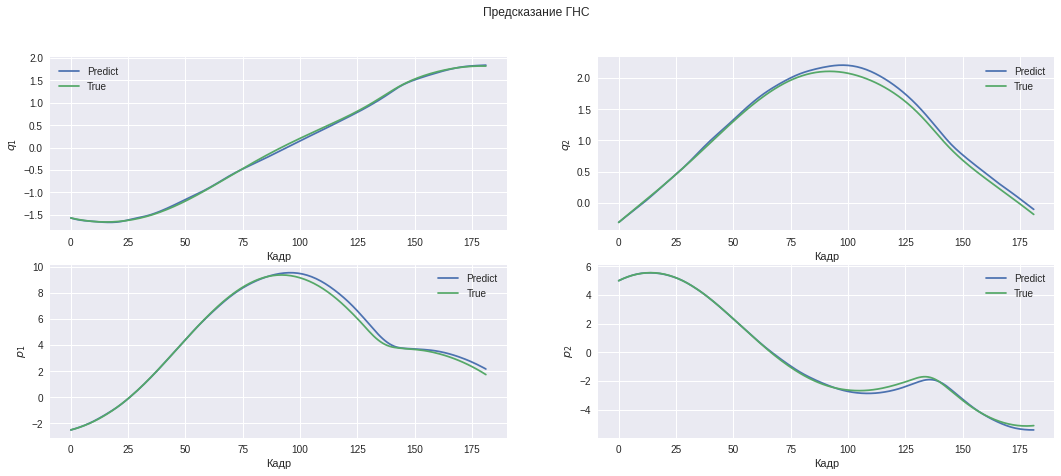

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 7))
names = {0:r"q_1", 1:"q_2", 2:"p_1", 3:"p_2"}

fig.suptitle('Предсказание ГНС')

for i, p in enumerate([q1, q2, p1, p2]):
  ax[i//2, i%2].plot(p, label='Predict')
  ax[i//2, i%2].plot(x[0:frame, i], label='True')
  ax[i//2, i%2].set_ylabel(f'${names[i]}$')
  ax[i//2, i%2].set_xlabel(f'Кадр')
  ax[i//2, i%2].legend()
    
  
fig.savefig('/content/drive/MyDrive/Курсовая/Double Pendulum/train_predict_HNN', dpi=300)

# ОНС

In [ ]:
def BNN(shapes=(4, 200, 200, 2)):
  model = tf.keras.Sequential([
                               tf.keras.Input(shapes[0]),
                               tf.keras.layers.Dense(shapes[1], activation='tanh'),
                               tf.keras.layers.Dense(shapes[2], activation='tanh'),
                               tf.keras.layers.Dense(shapes[3], activation='linear')])
  

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.MeanSquaredError())
  
  return model

def integrate_BNN(model, t, y0, **kwargs):

  def S_h(t, x):
    x = tf.reshape(x, (1, 4))
    dx = model.predict(x)
    return dx

  return solve_ivp(S_h, t, y0, **kwargs)

In [ ]:
frame = 182
fps = 182
qstarts = np.linspace(-np.pi/2, 0, 6, endpoint=True)
pstarts = np.linspace(-5, 5, 5, endpoint=True)

In [ ]:
# Создание и обучение сети
bnn = BNN((4, 400, 400, 4))
history = bnn.fit(x, y, batch_size = frame, epochs=1, verbose=0)
start_time = time.time()
for i in range(10):
  data = np.concatenate(give_data(10, frame, qstarts, pstarts, fps=fps))
  x = data[:, :4]
  y = data[:, 4:]
  print(f'{i} Итерация')
  history.history['loss'].extend(bnn.fit(x, y, batch_size=frame, epochs=400, verbose=0).history['loss'])
  print(f'{history.history["loss"][-1]}')
  
time_bnn = time.time() - start_time

0 Итерация
0.022417806088924408
1 Итерация
0.04578981176018715
2 Итерация
0.024630747735500336
3 Итерация
0.007521762512624264
4 Итерация
0.02665574662387371
5 Итерация
0.061993278563022614
6 Итерация
0.007670660503208637
7 Итерация
0.06543026119470596
8 Итерация
0.03540975973010063
9 Итерация
0.02412126399576664


In [ ]:
print(f'Видим, что время тренировки примерно равно, с погрешностью на оптимизированность библиотеки: \nTIME BNN {time_bnn}, TIME HNN {time_hnn}')

Видим, что время тренировки примерно равно, с погрешностью на оптимизированность библиотеки: 
TIME BNN 240.62143111228943, TIME HNN 492.80877232551575


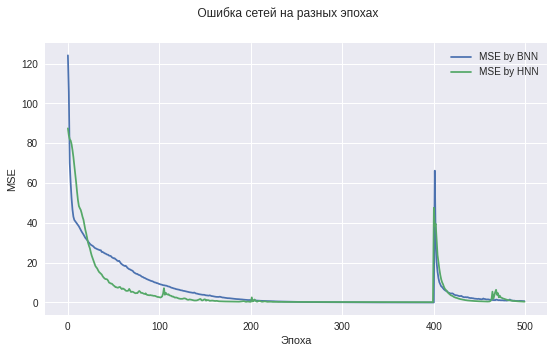

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

fig.suptitle(r' Ошибка сетей на разных эпохах ')

ax.plot(history.history['loss'][:500], label='MSE by BNN')
ax.plot(hnn.history_loss[:500], label='MSE by HNN')
ax.set_xlabel('Эпоха'), ax.set_ylabel('MSE')
ax.legend()


fig.savefig('/content/drive/MyDrive/Курсовая/Double Pendulum/MSE_dp', dpi=300)
print('')

In [ ]:
q1, q2, p1, p2 = integrate_HNN(hnn, [0, frame/fps], x[0], (4, 200, 200, 2), t_eval=np.linspace(0, frame/fps, frame, endpoint=True))['y'] #
q1_bnn, q2_bnn, p1_bnn, p2_bnn = integrate_BNN(bnn, [0, frame/fps], x[0], t_eval=np.linspace(0, frame/fps, frame, endpoint=True))['y']

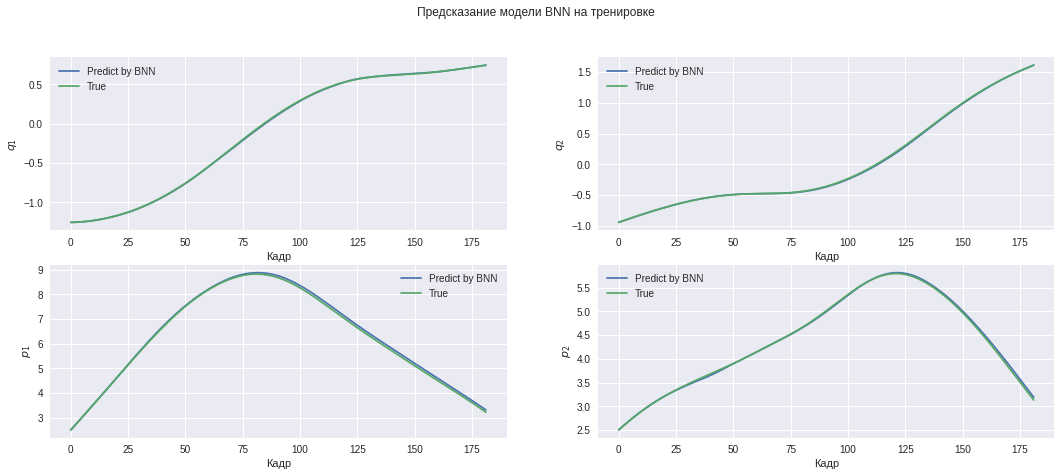

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 7))
names = {0:r"q_1", 1:"q_2", 2:"p_1", 3:"p_2"}
pb = [q1_bnn, q2_bnn, p1_bnn, p2_bnn]

fig.suptitle('Предсказание модели BNN на тренировке')

for i in range(4):
  
  ax[i//2, i%2].plot(pb[i], label='Predict by BNN')
  ax[i//2, i%2].plot(x[0:frame, i], label='True')
  ax[i//2, i%2].set_ylabel(f'${names[i]}$')
  ax[i//2, i%2].set_xlabel(f'Кадр')
  ax[i//2, i%2].legend()
    
fig.savefig('/content/drive/MyDrive/Курсовая/Double Pendulum/train_predict_BNN', dpi=300)
print('')

In [ ]:
x_test = [-np.pi/6, -np.pi/6, 3, 3]
q1, q2, p1, p2 = integrate_HNN(hnn, [0, frame/fps], x_test, (4, 200, 200, 2), t_eval=np.linspace(0, frame/fps, frame, endpoint=True))['y'] #
q1_bnn, q2_bnn, p1_bnn, p2_bnn = integrate_BNN(bnn, [0, frame/fps], x_test, t_eval=np.linspace(0, frame/fps, frame, endpoint=True))['y']
data_test = give_data(1, frame, x_test[:2], x_test[2:], fps)
q1_real, q2_real, p1_real, p2_real = data_test[0, :, 0], data_test[0, :, 1], data_test[0, :, 2], data_test[0, :, 3]


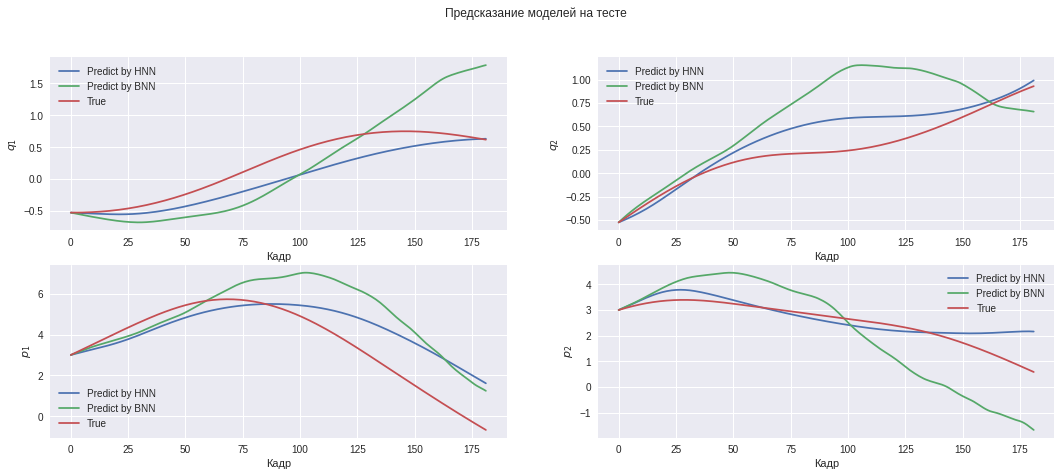

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 7))
names = {0:r"q_1", 1:"q_2", 2:"p_1", 3:"p_2"}
pb = [q1_bnn, q2_bnn, p1_bnn, p2_bnn]
preal = [q1_real, q2_real, p1_real, p2_real]

fig.suptitle('Предсказание моделей на тесте')

for i, p in enumerate([q1, q2, p1, p2]):
  ax[i//2, i%2].plot(p, label='Predict by HNN')
  ax[i//2, i%2].plot(pb[i], label='Predict by BNN')
  ax[i//2, i%2].plot(preal[i], label='True')
  ax[i//2, i%2].set_ylabel(f'${names[i]}$')
  ax[i//2, i%2].set_xlabel(f'Кадр')
  ax[i//2, i%2].legend()
    
fig.savefig('/content/drive/MyDrive/Курсовая/Double Pendulum/test_predict', dpi=300)
print('')

In [ ]:
print(f'BNN LOSS: {sum((q1_bnn - q1_real) ** 2 + (q2_bnn - q2_real) ** 2 + (p1_bnn - p1_real) ** 2 + (p2_bnn - p2_real) ** 2 )}')
print(f'HNN LOSS: {sum((q1 - q1_real) ** 2 + (q2 - q2_real) ** 2 + (p1 - p1_real) ** 2 + (p2 - p2_real) ** 2 )}')

BNN LOSS: 990.894651550576
HNN LOSS: 345.94480254211896


## Отрисовка

In [ ]:
frame = 182
fps = 182
x_1, y_1 = give_coord(x_test, frame=frame, fps=fps)
x_2, y_2 = give_coord(None, frame, fps, [q1, q2, p1, p2])
x_3, y_3 = give_coord(None, frame, fps, [q1_bnn, q2_bnn, p1_bnn, p2_bnn])

create_film('Два маятника с предсказаниями', '/content/drive/MyDrive/Курсовая/Double Pendulum/dp_pred', 
            x_1, y_1, x_2, y_2, x_3, y_3, frame=frame, names=['True', 'Predict by HNN', 'Predict by BNN'])



In [ ]:
# Запись в гиф
clip = VideoFileClip('/content/drive/MyDrive/Курсовая/Double Pendulum/dp_pred.mp4')
clip.write_gif('/content/drive/MyDrive/Курсовая/Double Pendulum/dp_pred.gif')


[MoviePy] Building file /content/drive/MyDrive/Курсовая/Double Pendulum/dp_pred.gif with imageio


100%|██████████| 182/182 [00:12<00:00, 14.88it/s]
